# Multinomial Naive Bayes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import learning_curve

import joblib

In [2]:
# X = df[['author', 'content', 'poem name']].apply(lambda x: ' '.join(x.astype(str)), axis=1)

Read in training data:

In [3]:
X_train = pd.read_csv('../data/train/X_train.csv')
y_train = np.ravel(pd.read_csv('../data/train/y_train.csv'))

In [4]:
def report(Y, pred):
    print('Confusion matrix: \n', confusion_matrix(Y, pred))
    print('\nClassification report: \n', classification_report(Y, pred, zero_division=True))

In [5]:
def learning_curves(estimator, X, Y, train_sizes, cv, scoring = "accuracy"):
    
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, X, Y, train_sizes = train_sizes, cv = cv, scoring = scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training ' + scoring)
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation ' + scoring)

    plt.ylabel(scoring, fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()

### Model creating and training:

Before we create and start to train our model, lets test it for which hyperparameters it works the best.

In [6]:
params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 10.0, ],
          'fit_prior': [True, False]
         }

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=3, verbose=5)
multinomial_nb_grid.fit(X_train,y_train)

print('Best accuracy : {:.3f}'.format(multinomial_nb_grid.best_score_))
print('Best hyperparameters : {}\n'.format(multinomial_nb_grid.best_params_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best accuracy : 0.912
Best hyperparameters : {'alpha': 0.01, 'fit_prior': False}



In [7]:
model = MultinomialNB(alpha= 0.01, class_prior= None, fit_prior= False)
model.fit(X_train, y_train, sample_weight = 1)

MultinomialNB(alpha=0.01, fit_prior=False)

### Prediction on training set:

In [8]:
y_train_pred = model.predict(X_train)
report(y_train, y_train_pred)

Confusion matrix: 
 [[162   0]
 [  0 192]]

Classification report: 
               precision    recall  f1-score   support

      Modern       1.00      1.00      1.00       162
 Renaissance       1.00      1.00      1.00       192

    accuracy                           1.00       354
   macro avg       1.00      1.00      1.00       354
weighted avg       1.00      1.00      1.00       354



In [9]:
# learning_curves(model, X_train, y_train, np.linspace(0.7, 1.0, 10), 5, scoring = "accuracy")

### Testing model:

Read in test data:

In [10]:
X_test = pd.read_csv('../data/test/X_test.csv')
y_test = np.ravel(pd.read_csv('../data/test/y_test.csv'))

In [11]:
y_test_pred = model.predict(X_test)
report(y_test, y_test_pred)

Confusion matrix: 
 [[49 11]
 [ 0 92]]

Classification report: 
               precision    recall  f1-score   support

      Modern       1.00      0.82      0.90        60
 Renaissance       0.89      1.00      0.94        92

    accuracy                           0.93       152
   macro avg       0.95      0.91      0.92       152
weighted avg       0.94      0.93      0.93       152



#### Saving predictions and probablilities for model comparison:

In [12]:
pd.DataFrame(y_test_pred).to_csv('results/mnb_pred.csv', index=False)
pd.DataFrame(model.predict_proba(X_test)[:,1]).to_csv('results/mnb_prob.csv', index=False)

#### Saving model:

In [13]:
joblib.dump(model, 'models/mnbModel.joblib')

['models/mnbModel.joblib']

### ROC curve - for train and for test data

In [14]:
Encoder = LabelEncoder()
y_test = Encoder.fit_transform(y_test)
y_train = Encoder.fit_transform(y_train)

In [15]:
#test data
y_score1 = model.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
test_score = round(roc_auc_score(y_test, y_score1), 2)
#training data
y_score2 = model.predict_proba(X_train)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_train, y_score2)
val_score = round(roc_auc_score(y_train, y_score2), 2)

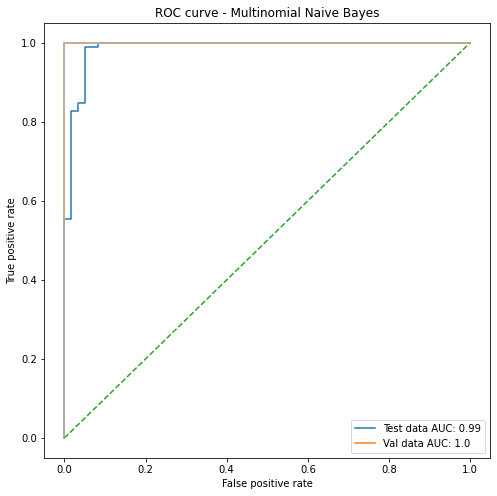

In [16]:
plt.subplots(1, figsize=(8,8))
plt.title('ROC curve - Multinomial Naive Bayes')
#roc curve for test data
plt.plot(false_positive_rate1, true_positive_rate1, label="Test data AUC: " + str(test_score))
#roc curve for val data
plt.plot(false_positive_rate2, true_positive_rate2, label="Val data AUC: " + str(val_score))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.legend(loc='lower right')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()